<a href="https://colab.research.google.com/github/ovieimara/ITNPAI1/blob/master/Predicting_customer_signups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
# Load the dataset
df = pd.read_csv('wallacecommunications.csv')

# Drop irrelevant columns (e.g., ID)
df = df.drop('ID', axis=1)

# Handle missing values (if any)
df = df.fillna('unknown')

# Split features and target
X = df.drop('new_contract_this_campaign', axis=1)
y = df['new_contract_this_campaign'].map({'yes': 1, 'no': 0})  # Convert to binary

# Define categorical and numerical columns
#categorical_cols = ['town', 'country', 'job', 'married', 'education', 'arrears', 'housing', 'has_tv_package', 'last_contact', 'outcome_previous_campaign']

categorical_cols = ['town', 'job', 'married', 'education', 'arrears', 'housing', 'has_tv_package', 'last_contact', 'outcome_previous_campaign']
numerical_cols = ['age', 'current_balance', 'conn_tr', 'last_contact_this_campaign_day', 'days_since_last_contact_previous_campaign']

# Preprocess data: One-hot encode categorical features and scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# X_processed = preprocessor.fit_transform(X)
# print(X_processed.toarray())
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train = X_processed = preprocessor.fit_transform(X_train)

# Initialize and train the model
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)

# Predictions
X_test = preprocessor.transform(X_test)
y_pred_logreg = logreg.predict(X_test)

# Evaluate
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_logreg):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_logreg):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_logreg):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_logreg):.2f}")

Logistic Regression Metrics:
Accuracy: 0.69
Precision: 0.35
Recall: 0.65
F1-Score: 0.45
ROC-AUC: 0.68


In [ ]:
# Initialize and train the model
dtree = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
dtree.fit(X_train, y_train)

# Predictions
y_pred_dtree = dtree.predict(X_test)

# Evaluate
print("\nDecision Tree Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dtree):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_dtree):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_dtree):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dtree):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_dtree):.2f}")

# Feature importance (optional)
feature_importances = dtree.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance_df.head(20))


Decision Tree Metrics:
Accuracy: 0.74
Precision: 0.38
Recall: 0.58
F1-Score: 0.46
ROC-AUC: 0.68

Feature Importance:
                                            Feature  Importance
138          cat__outcome_previous_campaign_success    0.444946
135                       cat__last_contact_unknown    0.254970
128                                cat__housing_yes    0.115715
1                              num__current_balance    0.077879
131                         cat__has_tv_package_yes    0.033023
4    num__days_since_last_contact_previous_campaign    0.024555
0                                          num__age    0.018799
120                             cat__married_single    0.013990
119                            cat__married_married    0.007662
123                         cat__education_tertiary    0.003419
127                                 cat__housing_no    0.001398
95                                cat__town_Telford    0.001025
3               num__last_contact_this_campaign_da

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Define class weights
class_weights = {0: 1, 1: 5}  # Higher weight for the minority class

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    X_train.toarray(), y_train,  # Use `.toarray()` if using sparse matrices
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1

)

# Predictions
y_pred_nn = (model.predict(X_test.toarray()) >= 0.5).astype("int32")

# Evaluate
print("\nNeural Network Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_nn):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_nn):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_nn):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_nn):.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5833 - loss: 1.1092 - val_accuracy: 0.6415 - val_loss: 0.6579
Epoch 2/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6641 - loss: 1.0439 - val_accuracy: 0.6297 - val_loss: 0.6730
Epoch 3/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6666 - loss: 1.0373 - val_accuracy: 0.7280 - val_loss: 0.5796
Epoch 4/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6747 - loss: 1.0306 - val_accuracy: 0.6677 - val_loss: 0.6493
Epoch 5/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6844 - loss: 1.0109 - val_accuracy: 0.6896 - val_loss: 0.6099
Epoch 6/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6892 - loss: 1.0084 - val_accuracy: 0.6797 - val_loss: 0.6246
Epoch 7/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6884 - loss: 0.9919 - val_accuracy: 0.6648 - val_loss: 0.6247
Epoch 8/50
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6896 - loss: 0.9752 - 

In [ ]:
def replace_value(df: np.array, column: str, old_value: str, new_value: str) -> None:
  # return df.assign(column=df[column].mask(df[column] == old_value, new_value))
  df[column] = df[column].apply(lambda x: new_value if x == old_value else x)
  return df

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load the dataset
df = pd.read_csv('wallacecommunications.csv')

# Drop irrelevant columns (e.g., ID)
df = df.drop('ID', axis=1)

# Handle missing values (if any)
df = df.fillna('unknown')

# Split features and target
X = df.drop('new_contract_this_campaign', axis=1)
y = df['new_contract_this_campaign'].map({'yes': 1, 'no': 0})  # Convert to binary

# Define categorical and numerical columns
categorical_cols = ['town', 'country', 'job', 'married', 'education', 'arrears', 'housing', 'has_tv_package', 'last_contact', 'outcome_previous_campaign']
numerical_cols = ['age', 'current_balance', 'conn_tr', 'last_contact_this_campaign_day', 'days_since_last_contact_previous_campaign']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Define the pipeline
logreg_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),  # Preprocessing step
    ('smote', SMOTE(random_state=42)),  # SMOTE for balancing
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))  # Model
])

# Train the pipeline
logreg_pipeline.fit(X_train, y_train)

# Predictions
y_pred_logreg_smote = logreg_pipeline.predict(X_test)

# Evaluate
print("Logistic Regression with SMOTE Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg_smote):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_logreg_smote):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_logreg_smote):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_logreg_smote):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_logreg_smote):.2f}")

Logistic Regression with SMOTE Metrics:
Accuracy: 0.69
Precision: 0.34
Recall: 0.65
F1-Score: 0.45
ROC-AUC: 0.67


In [ ]:
# Define the pipeline
dtree_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),  # Preprocessing step
    ('smote', SMOTE(random_state=42)),  # SMOTE for balancing
    ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))  # Model
])

# Train the pipeline
dtree_pipeline.fit(X_train, y_train)

# Predictions
y_pred_dtree_smote = dtree_pipeline.predict(X_test)

# Evaluate
print("\nDecision Tree with SMOTE Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dtree_smote):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_dtree_smote):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_dtree_smote):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dtree_smote):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_dtree_smote):.2f}")


Decision Tree with SMOTE Metrics:
Accuracy: 0.73
Precision: 0.38
Recall: 0.58
F1-Score: 0.46
ROC-AUC: 0.67


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the dataset
df = pd.read_csv('wallacecommunications.csv')

# Step 1: Feature Engineering
# Create new features or transform existing ones
df['days_since_last_contact_binned'] = pd.cut(df['days_since_last_contact_previous_campaign'], bins=[-1, 30, 90, 365, np.inf], labels=['recent', 'moderate', 'long_ago', 'very_long_ago'])
df['balance_to_age_ratio'] = df['current_balance'] / (df['age'])  # Avoid division by zero

# Step 2: Encode categorical variables
categorical_features = ['last_contact_this_campaign_month', 'days_since_last_contact_binned']
numerical_features = ['days_since_last_contact_previous_campaign', 'current_balance', 'last_contact_this_campaign_day', 'balance_to_age_ratio']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Step 3: Prepare the data
# Filter rows where outcome_previous_campaign is not "unknown" or "other"
train_data = df[~df['outcome_previous_campaign'].isin(['unknown', 'other'])]

# Encode the target variable
train_data['outcome_encoded'] = train_data['outcome_previous_campaign'].map({'success': 1, 'failure': 0})
train_data.loc[:, 'outcome_encoded'] = train_data['outcome_previous_campaign'].map({'success': 1, 'failure': 0})

# Features (X) and target (y)
X = train_data[numerical_features + categorical_features]
y = train_data['outcome_encoded']

# Step 4: Resampling to handle class imbalance
smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Preprocess the data (encode categorical features and scale numerical features)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Step 7: Feature Selection
# Use Random Forest to select important features
selector = SelectFromModel(RandomForestClassifier(random_state=42))
X_train_selected = selector.fit_transform(X_train_preprocessed, y_train)
X_test_selected = selector.transform(X_test_preprocessed)

# Step 8: Define models and hyperparameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [200],
            'max_depth': [20],
            'min_samples_split': [2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [200],
            'max_depth': [7],
            'learning_rate': [0.2]
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [10],
            'kernel': ['rbf']
        }
    }
}

# Step 9: Train and evaluate models
results = {}
for model_name, config in models.items():
    print(f"Training {model_name}...")

    # Grid Search for hyperparameter tuning
    grid_search = GridSearchCV(config['model'], config['params'], cv=5, scoring='accuracy')
    grid_search.fit(X_train_selected, y_train)

    # Best model from Grid Search
    best_model = grid_search.best_estimator_

    # Cross-validation
    cv_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='accuracy')

    # Test set evaluation
    y_pred = best_model.predict(X_test_selected)
    y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

    # Store results
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'cv_accuracy': cv_scores.mean(),
        'test_accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'best_model': best_model
    }

# Step 10: Print results
for model_name, result in results.items():
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Cross-Validation Accuracy: {result['cv_accuracy']:.4f}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"ROC-AUC Score: {result['roc_auc']:.4f}")
    print("Classification Report:\n", result['classification_report'])


# Step 11: Predict and update 'outcome_previous_campaign' for rows with "unknown" or "other"
# Choose the best model (e.g., RandomForest, XGBoost, or SVM) based on the results
best_model_name = max(results, key=lambda k: results[k]['test_accuracy'])
best_model = results[best_model_name]['best_model']

# Filter rows where outcome_previous_campaign is "unknown" or "other"
predict_data = df[df['outcome_previous_campaign'].isin(['unknown', 'other'])]

# Preprocess the prediction data
X_predict = predict_data[numerical_features + categorical_features]
X_predict_preprocessed = preprocessor.transform(X_predict)

# Select important features (if feature selection was used)
X_predict_selected = selector.transform(X_predict_preprocessed)

# Predict outcomes
predict_data['predicted_outcome'] = best_model.predict(X_predict_selected)

# Map predicted values back to original labels
predict_data['predicted_outcome'] = predict_data['predicted_outcome'].map({1: 'success', 0: 'failure'})

# Update the original dataset with predicted values
df.loc[predict_data.index, 'outcome_previous_campaign'] = predict_data['predicted_outcome']

# Save the updated dataset (optional)
df.to_csv('updated_wallacecommunications.csv', index=False)

<ipython-input-81-f7809c4ca3fe>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['outcome_encoded'] = train_data['outcome_previous_campaign'].map({'success': 1, 'failure': 0})


Training RandomForest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Training SVM...

RandomForest Results:
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Cross-Validation Accuracy: 0.8600
Test Accuracy: 0.8963
ROC-AUC Score: 0.9218
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      1099
           1       0.83      0.83      0.83       482

    accuracy                           0.90      1581
   macro avg       0.88      0.88      0.88      1581
weighted avg       0.90      0.90      0.90      1581


XGBoost Results:
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Cross-Validation Accuracy: 0.8467
Test Accuracy: 0.8722
ROC-AUC Score: 0.9018
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1099
           1       0.79      0.79      0.79       482

    accuracy                           0.87      1581
   macro avg       0.85      0.85    

<ipython-input-81-f7809c4ca3fe>:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['predicted_outcome'] = best_model.predict(X_predict_selected)
<ipython-input-81-f7809c4ca3fe>:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['predicted_outcome'] = predict_data['predicted_outcome'].map({1: 'success', 0: 'failure'})


RandomForest Results:
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Cross-Validation Accuracy: 0.8567
Test Accuracy: 0.8779
ROC-AUC Score: 0.9143
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      1099
           1       0.79      0.82      0.80       482

    accuracy                           0.88      1581
   macro avg       0.85      0.86      0.86      1581
weighted avg       0.88      0.88      0.88      1581


XGBoost Results:
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Cross-Validation Accuracy: 0.8493
Test Accuracy: 0.8779
ROC-AUC Score: 0.8978
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1099
           1       0.80      0.80      0.80       482

    accuracy                           0.88      1581
   macro avg       0.86      0.86      0.86      1581
weighted avg       0.88      0.88      0.88      1581



SVM Results:
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Cross-Validation Accuracy: 0.7384
Test Accuracy: 0.7426
ROC-AUC Score: 0.7592
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      1099
           1       0.58      0.58      0.58       482

    accuracy                           0.74      1581
   macro avg       0.70      0.70      0.70      1581
weighted avg       0.74      0.74      0.74      1581

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv('wallacecommunications.csv')

# Step 1: Feature Engineering
df['days_since_last_contact_binned'] = pd.cut(df['days_since_last_contact_previous_campaign'], bins=[-1, 30, 90, 365, np.inf], labels=['recent', 'moderate', 'long_ago', 'very_long_ago'])
df['balance_to_age_ratio'] = df['current_balance'] / (df['age'] + 1)

# Step 2: Encode categorical variables
categorical_features = ['last_contact_this_campaign_month']
numerical_features = ['age', 'days_since_last_contact_previous_campaign', 'current_balance', 'last_contact_this_campaign_day']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Step 3: Prepare the data
train_data = df[~df['outcome_previous_campaign'].isin(['unknown', 'other'])]
train_data['outcome_encoded'] = train_data['outcome_previous_campaign'].map({'success': 1, 'failure': 0})

X = train_data[numerical_features + categorical_features]
y = train_data['outcome_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Models and parameters

models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, max_depth = 20, min_samples_split = 2, n_estimators = 200),
        'params': {
            # 'pca__n_components': [10, 20],
            'selector__estimator__n_estimators': [100, 200],
            'selector__estimator__max_depth': [None, 10],
            'selector__estimator__min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            # 'pca__n_components': [10, 20],
            'selector__estimator__n_estimators': [100, 200],
            'selector__estimator__max_depth': [3, 5],
            'selector__estimator__learning_rate': [0.01, 0.1]
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            # 'pca__n_components': [10, 20],
            'classifier__C': [0.1, 1],
            'classifier__kernel': ['linear', 'rbf']
        }
    },
    'MLP': {
        'model': MLPClassifier(random_state=42),
        'params': {
            # 'pca__n_components': [10, 20],
            'classifier__hidden_layer_sizes': [(50,), (100,)],
            'classifier__alpha': [0.0001, 0.001],
            'classifier__max_iter': [200, 300]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42, class_weight= 'balanced', max_depth = 40, max_features = 'sqrt', max_leaf_nodes = None, min_samples_leaf = 1, min_samples_split = 2, splitter= 'best'),
        'params': {
            # 'pca__n_components': [10, 20],
            # 'classifier__max_depth': [None, 10, 20],
            # 'classifier__min_samples_split': [2, 5, 10]
        }
    }
}

results = {}
for model_name, config in models.items():
    print(f"Training {model_name}...")

    if model_name in ['SVM', 'MLP', 'DecisionTree']:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            # ('smote', SMOTE(random_state=42)),
            # ('pca', PCA(random_state=42)),
            ('classifier', config['model'])
        ])
    else:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            # ('smote', SMOTE(random_state=42)),
            # ('pca', PCA(random_state=42)),
            ('selector', SelectFromModel(config['model'])),
            ('classifier', config['model'])
        ])

    grid_search = GridSearchCV(pipeline, config['params'], cv=10, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    results[model_name] = {
        'best_params': grid_search.best_params_,
        'cv_accuracy': cv_scores.mean(),
        'test_accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'best_model': best_model
    }

# Step 10: Print results
for model_name, result in results.items():
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Cross-Validation Accuracy: {result['cv_accuracy']:.4f}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"ROC-AUC Score: {result['roc_auc']:.4f}")
    print("Classification Report:\n", result['classification_report'])

# Step 11: Predict and update 'outcome_previous_campaign' for rows with "unknown" or "other"
best_model_name = max(results, key=lambda k: results[k]['test_accuracy'])
best_model = results[best_model_name]['best_model']

predict_data = df[df['outcome_previous_campaign'].isin(['unknown', 'other'])].copy()
X_predict = predict_data[numerical_features + categorical_features]

predict_data['predicted_outcome'] = best_model.predict(X_predict)
predict_data['predicted_outcome'] = predict_data['predicted_outcome'].map({1: 'success', 0: 'failure'})
df.loc[predict_data.index, 'outcome_previous_campaign'] = predict_data['predicted_outcome']

df.to_csv('updated_wallacecommunications2.csv', index=False)

<ipython-input-9-ebfc20a8587f>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['outcome_encoded'] = train_data['outcome_previous_campaign'].map({'success': 1, 'failure': 0})


Training RandomForest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:03:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:03:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:03:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:03:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:03:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Training SVM...
Training MLP...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Training DecisionTree...

RandomForest Results:
Best Parameters: {'selector__estimator__max_depth': None, 'selector__estimator__min_samples_split': 2, 'selector__estimator__n_estimators': 100}
Cross-Validation Accuracy: 0.9110
Test Accuracy: 0.9007
ROC-AUC Score: 0.9446
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      1100
           1       0.85      0.82      0.83       481

    accuracy                           0.90      1581
   macro avg       0.89      0.88      0.88      1581
weighted avg       0.90      0.90      0.90      1581


XGBoost Results:
Best Parameters: {'selector__estimator__learning_rate': 0.01, 'selector__estimator__max_depth': 3, 'selector__estimator__n_estimators': 100}
Cross-Validation Accuracy: 0.8667
Test Accuracy: 0.8482
ROC-AUC Score: 0.8967
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      1100
        

RandomForest Results:
Best Parameters: {'selector__estimator__max_depth': None, 'selector__estimator__min_samples_split': 2, 'selector__estimator__n_estimators': 100}
Cross-Validation Accuracy: 0.8928
Test Accuracy: 0.8684
ROC-AUC Score: 0.9206
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      1100
           1       0.74      0.86      0.80       481

    accuracy                           0.87      1581
   macro avg       0.84      0.87      0.85      1581
weighted avg       0.88      0.87      0.87      1581


XGBoost Results:
Best Parameters: {'selector__estimator__learning_rate': 0.01, 'selector__estimator__max_depth': 3, 'selector__estimator__n_estimators': 200}
Cross-Validation Accuracy: 0.8583
Test Accuracy: 0.8299
ROC-AUC Score: 0.8770
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87      1100
           1       0.69      0.80      0.74       481

    accuracy                           0.83      1581
   macro avg       0.80      0.82      0.81      1581
weighted avg       0.84      0.83      0.83      1581


SVM Results:
Best Parameters: {'selector__estimator__C': 0.1, 'selector__estimator__kernel': 'linear'}
Cross-Validation Accuracy: 0.6923
Test Accuracy: 0.7217
ROC-AUC Score: 0.7216
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.72      0.78      1100
           1       0.53      0.72      0.61       481

    accuracy                           0.72      1581
   macro avg       0.69      0.72      0.70      1581
weighted avg       0.76      0.72      0.73      1581

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance


# Load the dataset
# df = pd.read_csv('updated_wallacecommunications.csv')

# Drop irrelevant columns (e.g., ID)
df = df.drop('ID', axis=1)

# df = df[df['this_campaign'] <= 10]


df["has_tv_package"] = df["has_tv_package"].replace({ 'n' : 'no'})
df['last_contact_this_campaign_month'] = df["last_contact_this_campaign_month"].replace({ 'j' : 'jul'})
df['days_since_last_contact_previous_campaign'] = df["days_since_last_contact_previous_campaign"].replace({ -1 : 0})
# df["has_tv_package"] = df["has_tv_package"].replace({ 'n' : 'no'})

# df["last_contact_this_campaign_month"].mask(df["has_tv_package"] == 'j', 'jul', inplace=True)
# df["days_since_last_contact_previous_campaign"].mask(df["days_since_last_contact_previous_campaign"] == -1, 0, inplace=True)
df = df[df['age'] <= 70]
df = df[df['age'] >= 18]
# df = df[df['current_balance'] <= 65]
# df = df[df['current_balance'] >= 0]
# df = df[df['conn_tr'] <= 100]
# df = df[df['conn_tr'] >= 0]
# df = df[df['last_contact_this_campaign_day'] <= 31]
# df = df[df['last_contact_this_campaign_day'] >= 1]
# filter = df['job'] == 'unknown'
# df = df[filter]
# print(df.size)
df['last_contact_this_campaign_date'] = df['last_contact_this_campaign_day'].astype(str) + '-' + df['last_contact_this_campaign_month']
df['last_contact_this_campaign_date'] = pd.to_datetime(df['last_contact_this_campaign_date'], format='%d-%b')
# wa
# Handle missing values (if any)
# df.dropna()
# df.drop_duplicates(inplace=True)

# Split features and target
X = df.drop('new_contract_this_campaign', axis=1)
y = df['new_contract_this_campaign'].map({'yes': 1, 'no': 0})  # Convert to binary

# Define categorical and numerical columns
# categorical_cols = ['town', 'country', 'job', 'married', 'education', 'arrears', 'housing', 'has_tv_package', 'last_contact', 'outcome_previous_campaign']
categorical_cols = ['education', 'housing', 'has_tv_package', 'last_contact', 'last_contact_this_campaign_month', 'last_contact_this_campaign_date', 'outcome_previous_campaign']
numerical_cols = ['contacted_during_previous_campaign', 'this_campaign', 'last_contact_this_campaign_day', 'days_since_last_contact_previous_campaign']
# numerical_cols = ['current_balance', 'conn_tr', 'contacted_during_previous_campaign', 'this_campaign',

# categorical_cols = ['town', 'job', 'married', 'housing', 'has_tv_package', 'last_contact', 'outcome_previous_campaign', 'last_contact_this_campaign_date']
# numerical_cols = ['contacted_during_previous_campaign', 'this_campaign']

# Preprocessing pipeline
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_cols),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
#     ])

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Calculate class weights

# Step 3: Define class weights
class_weights = {0: 1, 1: 9}  # Higher weight for the minority class (class 1)

# Step 4: Map class weights to sample weights
sample_weights = [class_weights[cls] for cls in y_train]


# Identify categorical and numerical columns
# categorical_cols = X.select_dtypes(include=['object']).columns
# numerical_cols = X.select_dtypes(include=['number']).columns

# Create transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create pipeline with SMOTE and MLPClassifier
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    # ('smote', SMOTEENN(random_state=42)), #SMOTE for oversampling.
    ('classifier', MLPClassifier(activation = 'relu', alpha = 0.001, batch_size = 'auto', hidden_layer_sizes = (60,), learning_rate =  'adaptive', learning_rate_init = 0.01, max_iter = 50, solver = 'lbfgs'))

])
    # ('classifier', MLPClassifier(activation = 'relu', alpha = 0.0001, batch_size = 'auto', hidden_layer_sizes = (256, 128, 64), learning_rate =  'adaptive', learning_rate_init = 0.001, max_iter = 1000, solver = 'adam', verbose=False)) #Neural Network



# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Compute permutation importance
result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
feature_names = X_train.columns.tolist()
# Display feature importance with feature names
for i in result.importances_mean.argsort()[::-1]:
    print(f"{feature_names[i]}: {result.importances_mean[i]:.3f} ± {result.importances_std[i]:.3f}")

# Example of accessing the one hot encoder columns.
one_hot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
# print("One Hot encoded columns:", one_hot_columns)

#Example of accessing the numerical columns
# print("Numerical Columns:", numerical_cols)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8094
           1       0.69      0.42      0.52      1899

    accuracy                           0.85      9993
   macro avg       0.78      0.69      0.72      9993
weighted avg       0.84      0.85      0.84      9993

last_contact_this_campaign_month: 0.043 ± 0.002
last_contact: 0.024 ± 0.001
last_contact_this_campaign_date: 0.022 ± 0.002
days_since_last_contact_previous_campaign: 0.020 ± 0.001
outcome_previous_campaign: 0.019 ± 0.001
last_contact_this_campaign_day: 0.006 ± 0.001
housing: 0.005 ± 0.001
contacted_during_previous_campaign: 0.004 ± 0.001
this_campaign: 0.002 ± 0.001
education: 0.001 ± 0.001
has_tv_package: 0.001 ± 0.001
balance_to_age_ratio: 0.000 ± 0.000
days_since_last_contact_binned: 0.000 ± 0.000
conn_tr: 0.000 ± 0.000
current_balance: 0.000 ± 0.000
arrears: 0.000 ± 0.000
married: 0.000 ± 0.000
job: 0.000 ± 0.000
age: 0.000 ± 0.000
country: 0.000 ± 0.000
town: 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

# Load the dataset
df = pd.read_csv('updated_wallacecommunications.csv')

# Drop irrelevant columns (e.g., ID)
df = df.drop('ID', axis=1)

# Data Cleaning and Preprocessing
df["has_tv_package"] = df["has_tv_package"].replace({'n': 'no'})
df['last_contact_this_campaign_month'] = df["last_contact_this_campaign_month"].replace({'j': 'jul'})
df['days_since_last_contact_previous_campaign'] = df["days_since_last_contact_previous_campaign"].replace({-1: 0})
df = df[(df['age'] >= 18) & (df['age'] <= 70)]

# Feature Engineering
df['last_contact_this_campaign_date'] = pd.to_datetime(df['last_contact_this_campaign_day'].astype(str) + '-' + df['last_contact_this_campaign_month'], format='%d-%b')
df['day_of_week'] = df['last_contact_this_campaign_date'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)  # 1 if weekend, 0 otherwise

df['age_squared'] = df['age'] ** 2
df['campaign_duration'] = df['this_campaign'] * df['last_contact_this_campaign_day']
df['previous_contact_interaction'] = df['contacted_during_previous_campaign'] * df['days_since_last_contact_previous_campaign']

# Split features and target
X = df.drop(['new_contract_this_campaign', 'last_contact_this_campaign_date', 'day_of_week'], axis=1)  # Drop date column after feature extraction
y = df['new_contract_this_campaign'].map({'yes': 1, 'no': 0})

# Define categorical and numerical columns
categorical_cols = ['housing', 'has_tv_package', 'last_contact', 'last_contact_this_campaign_month', 'outcome_previous_campaign']
numerical_cols = ['contacted_during_previous_campaign', 'this_campaign', 'last_contact_this_campaign_day', 'days_since_last_contact_previous_campaign',
                  'is_weekend', 'age_squared', 'campaign_duration', 'previous_contact_interaction']

# Preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create pipeline with MLPClassifier
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', hidden_layer_sizes=(1000, 256), learning_rate='adaptive', learning_rate_init=0.01, max_iter=50, solver='adam'))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Compute permutation importance
result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
feature_names = X_train.columns.tolist()

# Display feature importance with feature names
for i in result.importances_mean.argsort()[::-1]:
    print(f"{feature_names[i]}: {result.importances_mean[i]:.3f} ± {result.importances_std[i]:.3f}")

# Accessing Processed Columns
one_hot_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
# print("One Hot encoded columns:", one_hot_columns)

# print("Numerical Columns:", numerical_cols)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.96      0.92      8094
           1       0.72      0.49      0.58      1899

    accuracy                           0.87      9993
   macro avg       0.80      0.72      0.75      9993
weighted avg       0.86      0.87      0.86      9993

last_contact_this_campaign_month: 0.139 ± 0.003
last_contact_this_campaign_day: 0.077 ± 0.002
last_contact: 0.051 ± 0.002
days_since_last_contact_previous_campaign: 0.049 ± 0.002
outcome_previous_campaign: 0.030 ± 0.001
age_squared: 0.024 ± 0.001
housing: 0.020 ± 0.001
contacted_during_previous_campaign: 0.020 ± 0.001
is_weekend: 0.015 ± 0.001
this_campaign: 0.015 ± 0.001
previous_contact_interaction: 0.011 ± 0.001
campaign_duration: 0.010 ± 0.001
has_tv_package: 0.007 ± 0.001
days_since_last_contact_binned: 0.000 ± 0.000
balance_to_age_ratio: 0.000 ± 0.000
conn_tr: 0.000 ± 0.000
current_balance: 0.000 ± 0.000
arrears: 0.000 ± 0.000
education: 0.000 ± 0.000
married

In [ ]:
def replace_value(df):
  df.head()

  df["has_tv_package"] = df["has_tv_package"].replace({'n': 'no'})
  df['last_contact_this_campaign_month'] = df["last_contact_this_campaign_month"].replace({'j': 'jul'})
  df['days_since_last_contact_previous_campaign'] = df["days_since_last_contact_previous_campaign"].replace({-1: 0})
  df['last_contact'] = df["last_contact"].replace({'cell': 'cellular'})


def engineer_features(df):
  df['last_contact_this_campaign_date'] = pd.to_datetime(df['last_contact_this_campaign_day'].astype(str) + '-' + df['last_contact_this_campaign_month'], format='%d-%b')
  df['day_of_week'] = df['last_contact_this_campaign_date'].dt.dayofweek
  df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
  # df['age_squared'] = df['age'] ** 2
  df['campaign_duration'] = df['this_campaign'] * df['last_contact_this_campaign_day']
  df['previous_contact_interaction'] = df['contacted_during_previous_campaign'] * df['days_since_last_contact_previous_campaign']

def drop_columns(df, columns):
  return df.drop(columns, axis=1)


Training Logistic Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ...................................classifier__C=10; total time=  12.5s
[CV] END ...................................classifier__C=10; total time=  12.1s
[CV] END ...................................classifier__C=10; total time=  13.4s
[CV] END ...................................classifier__C=10; total time=  13.3s
[CV] END ...................................classifier__C=10; total time=  11.5s
[CV] END ...................................classifier__C=20; total time=  13.9s
[CV] END ...................................classifier__C=20; total time=  15.5s
[CV] END ...................................classifier__C=20; total time=  15.5s
[CV] END ...................................classifier__C=20; total time=  15.5s
[CV] END ...................................classifier__C=20; total time=  12.4s
Training Decision Tree...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....

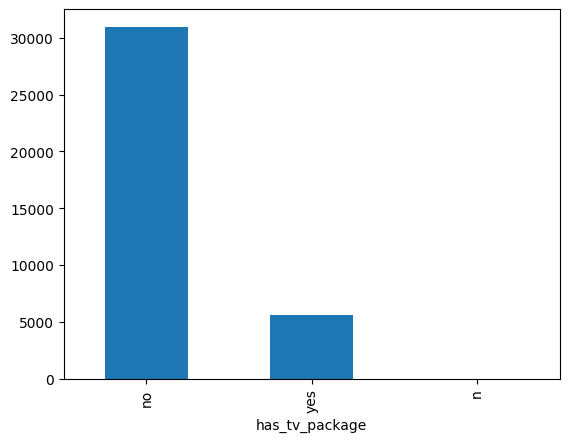

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE


# Load the dataset
df = pd.read_csv('updated_wallacecommunications2.csv')
# df = pd.read_csv('wallacecommunications.csv')

# Drop irrelevant columns (e.g., ID)
# df = df.drop('ID', axis=1)

# Split features and target
# X = df.drop(['ID', 'new_contract_this_campaign', 'last_contact_this_campaign_date', 'day_of_week', 'age_squared', 'conn_tr', 'town', 'days_since_last_contact_binned', 'this_campaign', 'current_balance', 'married', 'arrears', 'job', 'country'], axis=1)
X = drop_columns(df, ['ID', 'new_contract_this_campaign', 'conn_tr', 'town', 'days_since_last_contact_binned', 'current_balance', 'married', 'arrears', 'job', 'country'])
y = df['new_contract_this_campaign'].map({'yes': 1, 'no': 0})

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)
X_train['has_tv_package'].value_counts().plot(kind='bar')
# display(X_train.head())

# X_train["has_tv_package"] = X_train["has_tv_package"].replace({'n': 'no'})

# (X_train['has_tv_package'].value_counts().plot(kind='bar'))

# Data Cleaning and Preprocessing
# df["has_tv_package"] = df["has_tv_package"].replace({'n': 'no'})
# df['last_contact_this_campaign_month'] = df["last_contact_this_campaign_month"].replace({'j': 'jul'})
# df['days_since_last_contact_previous_campaign'] = df["days_since_last_contact_previous_campaign"].replace({-1: 0})
replace_value(X_train)

# df['last_contact'] = df["last_contact"].map({'cell': 'cellular'})
# df[df["last_contact"] == 'cell']

# df = df[(df['age'] >= 18) & (df['age'] <= 70)]

#binn age column:
# Define bins
# bins = [18, 25, 35, 50, 65, 80]
# labels = ['18-25', '26-35', '36-50', '51-65', '66+']
# df['age_bin'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
# df = df.drop('age', axis=1)

# Feature Engineering
# df['last_contact_this_campaign_date'] = pd.to_datetime(df['last_contact_this_campaign_day'].astype(str) + '-' + df['last_contact_this_campaign_month'], format='%d-%b')
# df['day_of_week'] = df['last_contact_this_campaign_date'].dt.dayofweek
# df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
# df['age_squared'] = df['age'] ** 2
# df['campaign_duration'] = df['this_campaign'] * df['last_contact_this_campaign_day']
# df['previous_contact_interaction'] = df['contacted_during_previous_campaign'] * df['days_since_last_contact_previous_campaign']
engineer_features(X_train)
X_train = drop_columns(X_train, ['last_contact_this_campaign_date', 'day_of_week', 'this_campaign'])



# Define categorical and numerical columns
categorical_cols = ['education', 'housing', 'has_tv_package', 'last_contact', 'last_contact_this_campaign_month', 'outcome_previous_campaign', 'balance_to_age_ratio']
# numerical_cols = ['contacted_during_previous_campaign', 'this_campaign', 'last_contact_this_campaign_day', 'days_since_last_contact_previous_campaign',
#                   'is_weekend', 'age_squared', 'campaign_duration', 'previous_contact_interaction']
numerical_cols = ['contacted_during_previous_campaign', 'last_contact_this_campaign_day', 'days_since_last_contact_previous_campaign',
                  'is_weekend', 'age', 'campaign_duration', 'previous_contact_interaction']

# Preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'params': {'classifier__C': [10, 20]}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42, class_weight= 'balanced', max_features = 'sqrt', max_leaf_nodes = None, min_samples_leaf = 1, min_samples_split = 2, splitter= 'best'),
        # 'params': {'classifier__max_depth': [None, 20, 30, 40, 50]}
        'params': {}
    },
    # 'Random Forest': {
    #     'model': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=200),
    #     # 'params': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [None, 10]}
    #     'params': {}
    # },
    #  'MLP Classifier': {
    #      'model': MLPClassifier(random_state=42, max_iter=200, activation='relu', alpha=0.001, batch_size='auto', hidden_layer_sizes=(50,), learning_rate='adaptive', learning_rate_init=0.01, solver='adam'),
    #      'params': {}
    # }
}


#Preprocess Validation Data
replace_value(X_val)
engineer_features(X_val)
X_val = drop_columns(X_val, ['last_contact_this_campaign_date', 'day_of_week', 'this_campaign'])


results = {}
for model_name, config in models.items():
    print(f"Training {model_name}...")
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        # ('smote', SMOTE(random_state=42)),
        ('classifier', config['model'])
    ])
    grid_search = GridSearchCV(pipeline, config['params'], cv=5, scoring=['balanced_accuracy', 'f1_weighted'], refit='balanced_accuracy', verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'classification_report': classification_report(y_val, y_pred, output_dict=True),
        'best_model': best_model
    }

# Print results
for model_name, result in results.items():
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {result['best_params']}")
    print("Classification Report:\n", result['classification_report'])

# Permutation Importance (example for Random Forest)
rf_pipeline = ImbPipeline(steps=[('preprocessor', preprocessor), ('classifier', models['Decision Tree']['model'])])
rf_pipeline.fit(X_train, y_train)

result = permutation_importance(rf_pipeline, X_val, y_val, n_repeats=5, random_state=42)
feature_names = X_train.columns.tolist()

print("\nDecision Tree Permutation Importance:")
for i in result.importances_mean.argsort()[::-1]:
    print(f"{feature_names[i]}: {result.importances_mean[i]:.3f} ± {result.importances_std[i]:.3f}")


Logistic Regression Results:
Best Parameters: {'classifier__C': 10}
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      5198
           1       0.68      0.79      0.73      1262

    accuracy                           0.89      6460
   macro avg       0.81      0.85      0.83      6460
weighted avg       0.89      0.89      0.89      6460


Decision Tree Results:
Best Parameters: {}
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      5198
           1       0.72      0.80      0.76      1262

    accuracy                           0.90      6460
   macro avg       0.83      0.86      0.85      6460
weighted avg       0.90      0.90      0.90      6460


Random Forest Results:
Best Parameters: {}
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      5198
           1       0.88      0.80      0.84      1262

    accuracy                           0.94      6460
   macro avg       0.92      0.89      0.90      6460
weighted avg       0.94      0.94      0.94      6460


MLP Classifier Results:
Best Parameters: {}
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      5198
           1       0.82      0.77      0.80      1262

    accuracy                           0.92      6460
   macro avg       0.88      0.87      0.88      6460
weighted avg       0.92      0.92      0.92      6460

[1 0 0 ... 0 0 0]
0.821671826625387


[Text(0.49107142857142855, 0.9, 'num__days_since_last_contact_previous_campaign <= -0.338\ngini = 0.34\nsamples = 6460\nvalue = [5055, 1405]\nclass = No'),
 Text(0.26785714285714285, 0.7, 'cat__last_contact_unknown <= 0.5\ngini = 0.283\nsamples = 5160\nvalue = [4278.0, 882.0]\nclass = No'),
 Text(0.3794642857142857, 0.8, 'True  '),
 Text(0.14285714285714285, 0.5, 'cat__last_contact_this_campaign_month_jun <= 0.5\ngini = 0.341\nsamples = 3478\nvalue = [2720, 758]\nclass = No'),
 Text(0.07142857142857142, 0.3, 'num__age <= 1.723\ngini = 0.327\nsamples = 3357\nvalue = [2665, 692]\nclass = No'),
 Text(0.03571428571428571, 0.1, 'gini = 0.312\nsamples = 3211\nvalue = [2591, 620]\nclass = No'),
 Text(0.10714285714285714, 0.1, 'gini = 0.5\nsamples = 146\nvalue = [74, 72]\nclass = No'),
 Text(0.21428571428571427, 0.3, 'num__age <= -1.599\ngini = 0.496\nsamples = 121\nvalue = [55, 66]\nclass = Yes'),
 Text(0.17857142857142858, 0.1, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = No'),
 Text(0.

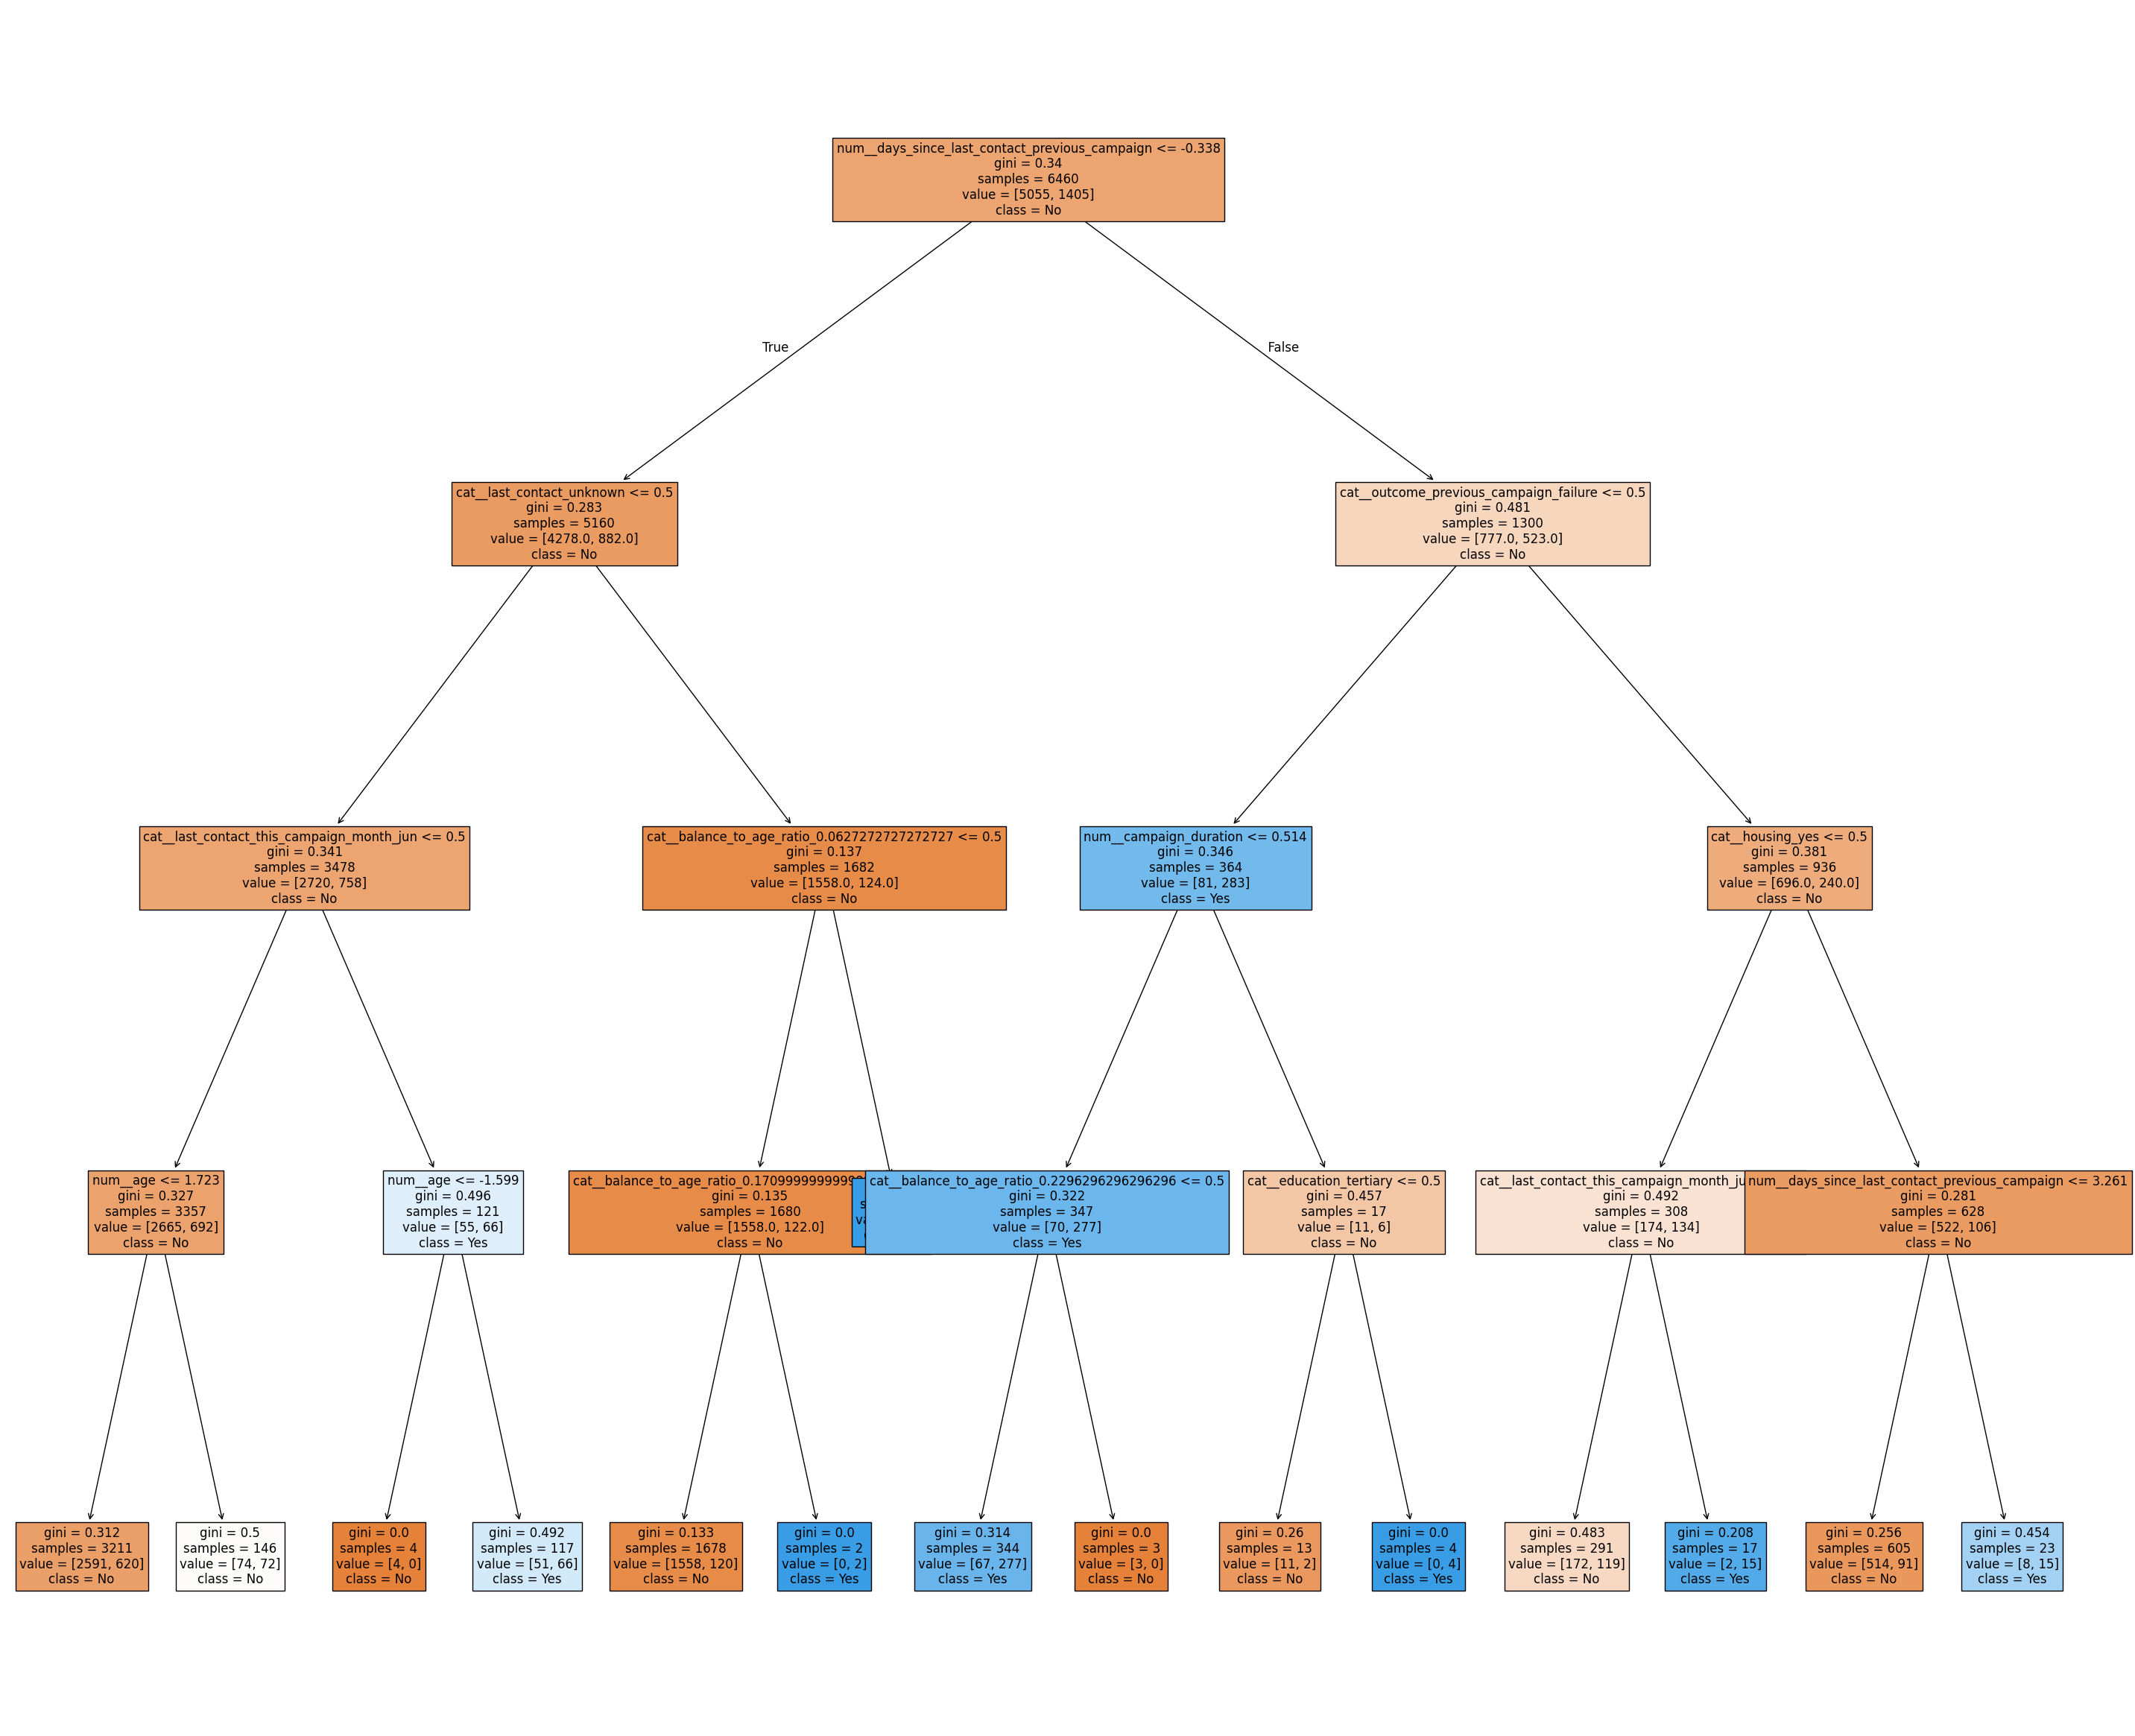

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

best_model = list(results.values())[1]['best_model']
y_pred = best_model.predict(X_val)
print(y_pred)
# print(X_val.head())
X_val_transform = preprocessor.fit_transform(X_val)
# print(X_val_transform)
# print(classification_report(y_val, y_pred))

surrogate_model = DecisionTreeClassifier(random_state=42, max_depth=4)
surrogate_model.fit(X_val_transform, y_pred)
surrogate_model_acc = surrogate_model.score(X_val_transform, y_pred)
print(surrogate_model_acc)

surrogate_pred = surrogate_model.predict(X_val_transform)

#display confusion matrix
# cm = confusion_matrix(y_pred, surrogate_pred)
# cmd = ConfusionMatrixDisplay(cm)
# cmd.plot()

plt.figure(figsize=(36, 30))
plot_tree(surrogate_model, filled=True, fontsize=12, class_names=['No', 'Yes'], feature_names=preprocessor.get_feature_names_out())



In [ ]:
df['previous_contact_interaction'] = df['contacted_during_previous_campaign'] * df['days_since_last_contact_previous_campaign']
  df['campaign_duration'] = df['this_campaign'] * df['last_contact_this_campaign_day']



Logistic Regression Results:
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      6115
           1       0.69      0.72      0.71      1485

    accuracy                           0.88      7600
   macro avg       0.81      0.82      0.82      7600
weighted avg       0.88      0.88      0.88      7600



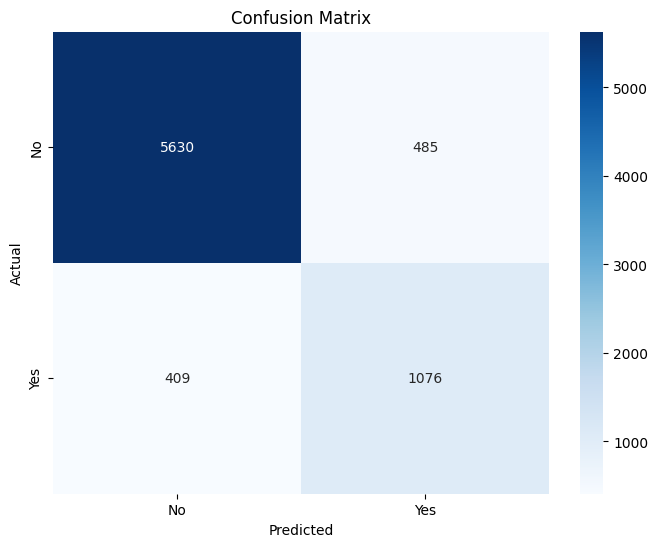


Decision Tree Results:
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      6115
           1       0.69      0.80      0.74      1485

    accuracy                           0.89      7600
   macro avg       0.82      0.86      0.84      7600
weighted avg       0.90      0.89      0.89      7600



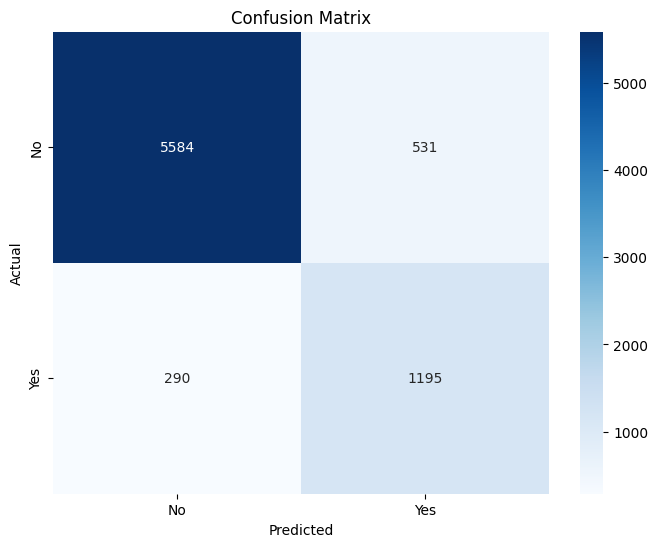

In [ ]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# X_val['has_tv_package'].value_counts().plot(kind='bar')

#Preprocess Test Data
replace_value(X_test)
engineer_features(X_test)
X_test = drop_columns(X_test, ['last_contact_this_campaign_date', 'day_of_week', 'this_campaign'])

#best_params, classification_report, best_model

results_test = {}
for  model_name, result in results.items():
    print(f"\n{model_name} Results:")
    best_model = result['best_model']
    y_pred = best_model.predict(X_test)

    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    plt.show()

Logistic Regression Results:
Best Parameters: {'classifier__C': 20}
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      8153
           1       0.79      0.65      0.71      1980

    accuracy                           0.90     10133
   macro avg       0.85      0.80      0.82     10133
weighted avg       0.89      0.90      0.89     10133


Decision Tree Results:
Best Parameters: {}
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      8153
           1       0.76      0.84      0.80      1980

    accuracy                           0.92     10133
   macro avg       0.86      0.89      0.87     10133
weighted avg       0.92      0.92      0.92     10133


Random Forest Results:
Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      8153
           1       0.90      0.83      0.87      1980

    accuracy                           0.95     10133
   macro avg       0.93      0.91      0.92     10133
weighted avg       0.95      0.95      0.95     10133


MLP Classifier Results:
Best Parameters: {}
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      8153
           1       0.85      0.78      0.82      1980

    accuracy                           0.93     10133
   macro avg       0.90      0.88      0.89     10133
weighted avg       0.93      0.93      0.93     10133


Decision Tree Permutation Importance:
last_contact_this_campaign_month: 0.132 ± 0.003
balance_to_age_ratio: 0.084 ± 0.001
outcome_previous_campaign: 0.069 ± 0.002
contacted_during_previous_campaign: 0.069 ± 0.003
last_contact: 0.059 ± 0.001
last_contact_this_campaign_day: 0.052 ± 0.001
education: 0.052 ± 0.003
housing: 0.049 ± 0.002
campaign_duration: 0.044 ± 0.001
age: 0.034 ± 0.001
is_weekend: 0.033 ± 0.002
days_since_last_contact_previous_campaign: 0.027 ± 0.001
has_tv_package: 0.026 ± 0.001
previous_contact_interaction: 0.011 ± 0.000

<Axes: title={'center': 'Count of has_tv_package'}, xlabel='has_tv_package', ylabel='count'>

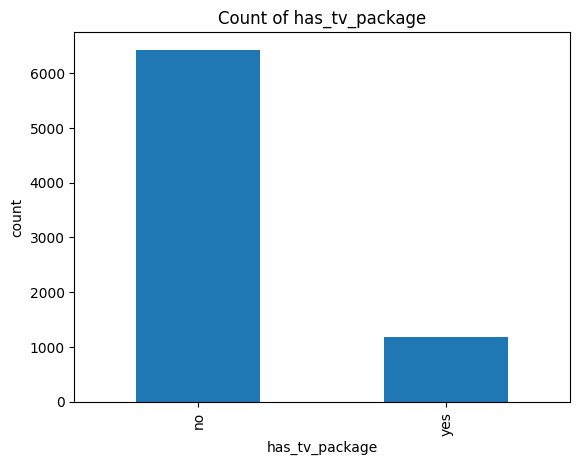

In [ ]:
#add label for x and y axis
replace_value(X_test)

X_test['has_tv_package'].value_counts().plot(kind='bar', xlabel='has_tv_package', ylabel='count', title='Count of has_tv_package')

In [ ]:
list(results.items())
surrogate_model = DecisionTreeClassifier(random_state=42, max_depths=3)
surrogate_model.fit(X_test, y_train)
y_pred = surrogate_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Create pipeline with MLPClassifier
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', hidden_layer_sizes=(1024, 512,), learning_rate='adaptive', learning_rate_init=0.01, max_iter=50, solver='adam'))
])